In [4]:
import numpy as np
import h5py
import scipy.io


In [59]:
# Loads KRAKEN data
def load_dataset(idx, shuffle, Nval):
    filepath = "files_116/files_VLA_rand_"+ str(idx) +"_116.mat"
    
    mat = scipy.io.loadmat(filepath)
    signal_train=np.array([], dtype=np.float)
  
    # Training data
    args = (mat['p_cl_n'], mat['p_si_n'], mat['p_sa_n'],mat['p_gr_n'])
    for v in args: 
        tmp=np.vstack([np.real(v), np.imag(v)]) 
        signal_train=np.hstack([signal_train, tmp]) if signal_train.size else tmp

    mats=[1500,  1575, 1650, 1800]
    labels_train=np.array([mats[int(np.floor(i/1000))] for i in range(4000)], dtype=np.float)
    
    # Test data
    signal_test=np.array([],dtype=np.float)
    labels_test=np.array([], dtype=np.float)
    
    for j in range(1):
        i=j+5
        args=(mat["p_cl_n"+str(i)], mat['p_si_n'+str(i)], mat["p_sa_n"+str(i)], mat["p_gr_n"+str(i)])
        for v in args: 
            tmp=np.vstack([np.real(v), np.imag(v)])
            signal_test=np.hstack([signal_test, tmp]) if signal_test.size else tmp

        labels_test=np.real(np.append([labels_test], [labels_train]))

    # Test labels are perturbed, associate them with the correct material type
    Y=labels_test
    labels=labels_test
    
    X = signal_train.transpose()
    y = labels_train
    X_test = signal_test.transpose()
    y_test = Y
    
    X = signal_train.transpose()
    y = labels_train
    X_test = signal_test.transpose()
    y_test = labels_test
    
    Nval
    ind=range(len(y))
    ind_train=ind[1:Nval]
    ind_val=ind[Nval:len(y)]
    ind_test = range(len(y_test))

  
    if shuffle:
        ind1 = np.random.permutation(len(y))
        ind_train=ind1[0:Nval]
        ind_val=ind1[Nval:len(y)]
        ind_test = np.random.permutation(len(y_test))
    
    X_train = np.array(X[ind_train,:], dtype = np.float)
    y_train = np.array(y[ind_train],)   
    X_val = np.array(X[ind_val,:], dtype = np.float)
    y_val = np.array(y[ind_val],) 
    X_test = np.array(X_test[ind_test,:], dtype = np.float)
    y_test = np.array(y_test[ind_test],)  
    return X_train, y_train, X_val, y_val, X_test, y_test


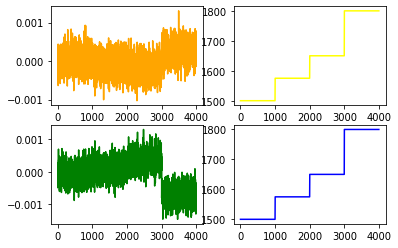

In [49]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import cm


X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(15, False, 3999)

f, ax = plt.subplots(2, 2, sharey=False, sharex=False)
ax[0][0].plot(X_train[:,13], color='orange')
ax[0][1].plot(y_train, color='yellow')
ax[1][0].plot(X_test[:,1], color='green')
ax[1][1].plot(y_test, color='blue')

In [50]:
from time import time
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Benchmark metrics for each classifier
# Adapted from Peter Prettenhofer, et. al,
# https://scikit-learn.org/0.19/auto_examples/text/document_classification_20newsgroups.html
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
   
    t0 = time()
    clf.fit(X_train, y_train)
    print(metrics.confusion_matrix(y_val, clf.predict(X_val)))
    results=clf.cv_results_
    candidates = np.flatnonzero(results['rank_test_score'] == 1)
    for candidate in candidates:
        print("Model with rank: {0}".format(1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})"
              .format(results['mean_test_score'][candidate],
                      results['std_test_score'][candidate]))
        print("Parameters: {0}".format(results['params'][candidate]))
        print("\n")

    target_names=[]
    targets=np.unique(y_train);

    for i in range(len(targets)):
        target_names.append(np.str(targets[i]))
    
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    
    print("test time:  %0.3fs" % test_time)
    
    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)
    print("classification report:")
    print(metrics.classification_report(y_test, pred, target_names=target_names))
    
    print("confusion matrix:")
    print(metrics.confusion_matrix(y_test, pred))

    clf_descr = str(str(clf.estimator))
    clf_rep = str(metrics.classification_report(y_test, pred, target_names=target_names))
    clf_cm = str(metrics.confusion_matrix(y_test, pred))
    return clf_descr, score, train_time, test_time, clf_rep, clf_cm
      

In [51]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform, expon
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis


# list of (estimator, param_dist), where param_dist is used  in RandomizedSearchCV
classifiers = [
     (GaussianProcessClassifier(warm_start=True, n_jobs=-1, random_state=42),{
        'max_iter_predict': [ 100, 200],
        'multi_class': ["one_vs_rest", "one_vs_one"],
        'n_restarts_optimizer':[0, 1]
     }),
     (KNeighborsClassifier(), {
         'n_neighbors': sp_randint(4, 10),
         'weights': ['uniform', 'distance'],
         'algorithm':['ball_tree', 'kd_tree'],
         'p': [1,2]
     }),
    (NearestCentroid(), {
         'metric': ['euclidean', 'manhattan','minkowski','chebyshev'],
         'shrink_threshold': [None, .001, .0001, .1, .01]
     }),
    (SVC(kernel='linear'), {
        'C': np.logspace(-1, 3, 100),
        'tol': np.logspace(-8, -2, 100)
    }),
    (SVC(random_state=42, gamma='scale'), {
        'C': [.1, 1, 10, 100, 1000],
        'kernel': ['rbf', 'poly', 'linear', 'sigmoid'], 
        'class_weight':['balanced', None],
        'tol': np.logspace(-8, -2, 100)
    }),
    (MLPClassifier(max_iter=100000), {
        'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
        'alpha': expon(scale=.1),
        'learning_rate': ['constant','adaptive'],
    }),
    (DecisionTreeClassifier(),{
        'criterion': ['gini', 'entropy'],
        'splitter': ['best','random'],
        'max_features':[None, 'auto', 'sqrt', 'log2'],
    }),
    (RandomForestClassifier(max_depth=5, n_jobs=-1), {
        "max_depth": sp_randint(2, 20),
        "n_estimators": sp_randint(2, 50),
        "max_features": ['auto', 'log2'],
        'class_weight': ['balanced', 'balanced_subsample'],
        'criterion': ['gini', 'entropy']
    }),
     (GaussianNB(), {
         'var_smoothing': np.logspace(-12, -8, 100)
     }), 
     (LinearDiscriminantAnalysis(n_components=2), {
         'solver': ['svd', 'lsqr'],
         'tol': np.logspace(-10, -2, 100)
     }),
     (LogisticRegression(solver='newton-cg', random_state=0, max_iter=100000), {
        'C': [.1, 1, 10, 100, 1000],
         'multi_class': ["auto", "ovr","multinomial"],
         'solver': ['sag', 'saga', 'newton-cg'],
         'tol': np.logspace(-6, -4, 100)
     }),
]
names = [e.__class__.__name__ for e, g in classifiers]

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
X_train, y_train,X_val, y_val, X_test, y_test= load_dataset(15, True, 3999)
X_val=X_train
y_val=y_train
target_names=[]
targets=np.unique(y_train);
for i in range(len(targets)):
        target_names.append(np.str(targets[i]))
        
# tests the classifiers without hyperparameter search
j=1
(clf, param_grid)=classifiers[j]
name=names[j]
print(name)
clf.fit(X_train, y_train)
pred=clf.predict(X_val)
print(metrics.confusion_matrix(y_val, pred))
print(metrics.classification_report(y_val, pred, target_names=target_names))
score = metrics.accuracy_score(y_val, pred)
print("val score:   %0.3f" % score)
pred=clf.predict(X_test)
print(metrics.confusion_matrix(y_test, pred))
print(metrics.classification_report(y_test, pred, target_names=target_names))
score = metrics.accuracy_score(y_test, pred)
print("test score:   %0.3f" % score)


KNeighborsClassifier
[[ 991    8    0    0]
 [   4  996    0    0]
 [   0    0 1000    0]
 [   0    0    0 1000]]
              precision    recall  f1-score   support

      1500.0       1.00      0.99      0.99       999
      1575.0       0.99      1.00      0.99      1000
      1650.0       1.00      1.00      1.00      1000
      1800.0       1.00      1.00      1.00      1000

    accuracy                           1.00      3999
   macro avg       1.00      1.00      1.00      3999
weighted avg       1.00      1.00      1.00      3999

val score:   0.997
[[ 467  527    6    0]
 [   1  994    5    0]
 [   0    0 1000    0]
 [   0    0    0 1000]]
              precision    recall  f1-score   support

      1500.0       1.00      0.47      0.64      1000
      1575.0       0.65      0.99      0.79      1000
      1650.0       0.99      1.00      0.99      1000
      1800.0       1.00      1.00      1.00      1000

    accuracy                           0.87      4000
   macro avg 

In [ ]:
## from sklearn.preprocessing import StandardScaler
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split


data_name=['KRAKEN 2 layer']
dset_name=data_name

noiselevel = np.array([15, 17 ,19, 21, 26, 30, 32 ,33, 60])
grid_searches = [dict() for x in range(len(noiselevel))]
results = [[] for x in range(len(noiselevel))]
ds_cnt=-1
for nl in noiselevel:
    ds_cnt=ds_cnt+1
    X_train, y_train, X_test, y_test= load_dataset(nl)
    
    print('\n Noise level:', str(nl),'\n')
   
    # iterate over classifiers
    for est_idx, (name, (estimator, param_grid)) in \
        enumerate(zip(names, classifiers)):

        # Perform randomized grid search over possible hyperparameters
        clf = RandomizedSearchCV(estimator=estimator, param_distributions=param_grid, n_iter=20, cv=5,
                                 verbose=0, n_jobs=-1)
        
        with ignore_warnings(category=ConvergenceWarning):
            results[ds_cnt].append(benchmark(clf))
        grid_searches[ds_cnt][name] = clf

        # Make predictions for the four test cases
        print(name)
        
        #print('Test Score', str(clf.score(X_test, y_test)))
      
        
    

In [ ]:
import datetime
# Displaying results to paste into latex
for nc in range(9):
    print("\\begin{filecontents}{"+names[nc]+"-kraken.dat}\n noise 	snr accuracy") 
    for nl in range(len(noiselevel)):
        clf_descr, score, train_time, test_time, clf_rep, clf_cm=results[nl][nc]
    
        print(str(noiselevel[nl])+" "+ str(18-nl)+" "+ str(score*100))
    print("\end{filecontents}")
    

In [ ]:
# Displaying results in a pandas dataframe
#Code adapted from https://www.kaggle.com/grfiv4/displaying-the-results-of-a-grid-search
import pandas as pd
def score_summary(grid_searches, sort_by='mean_test_score'):
        frames = []
        for name, grid_search in grid_searches.items():
            frame = pd.DataFrame(grid_search.cv_results_)
            frame = frame.filter(regex='^(?!.*param_).*$')
            frame['estimator'] = len(frame)*[name]
            frames.append(frame)
        df = pd.concat(frames)
        
        df = df.sort_values([sort_by], ascending=False)
        df = df.reset_index()
        df = df.drop(['rank_test_score', 'index'], 1)
        
        columns = df.columns.tolist()
        columns.remove('estimator')
        columns = ['estimator']+columns
        df = df[columns]
        return df

In [ ]:
df=score_summary(grid_searches[0])
print(noiselevel[0])
df